# Classification Texte

## Nettoyage de la colonne désignation

In [1]:
import pandas as pd
import numpy as np
import texthero as hero
import nltk
import nltk.data
import re
from nltk.corpus import stopwords
%matplotlib inline
from keras.utils import np_utils
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import metrics
import googletrans
from googletrans import Translator


df = pd.read_csv('df.csv')

from texthero import preprocessing
custom_pipeline = [preprocessing.fillna
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_html_tags
                   , preprocessing.remove_urls
                   , preprocessing.lowercase
                   , preprocessing.tokenize]

df['clean_title'] = hero.clean(df['designation'], pipeline = custom_pipeline)



from nltk.corpus import stopwords
stops = set(stopwords.words("french"))                  
#
def remove_stops(df):
    my_list = df['clean_title']
    meaningful_words = [w for w in my_list if not w in stops]
    return meaningful_words

df['clean_title'] = df.apply(remove_stops, axis=1)

# Test de traduction en français
# translator = Translator()
# df['trad'] = df['clean_title'].apply(translator.translate, dest='fr').apply(getattr, args=('text',))

df.head()


,productid,designation,description,imageid,prdtypecode,target,clean_title
0,3804725264,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,1263597046,10,0,"[olivia, personalisiertes, notizbuch, seiten, ..."
1,436067568,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,1008141237,2280,1,"[journal, arts, ndeg, art, marche, salon, art,..."
2,201115110,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,938777978,50,2,"[grand, stylet, ergonomique, bleu, gamepad, ni..."
3,50418756,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,457047496,1280,3,"[peluche, donald, europe, disneyland, marionne..."
4,278535884,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,1077757786,2705,4,"[guerre, tuques]"


## Graphique du nombre d'article par catégorie

/Users/lucasgandy/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

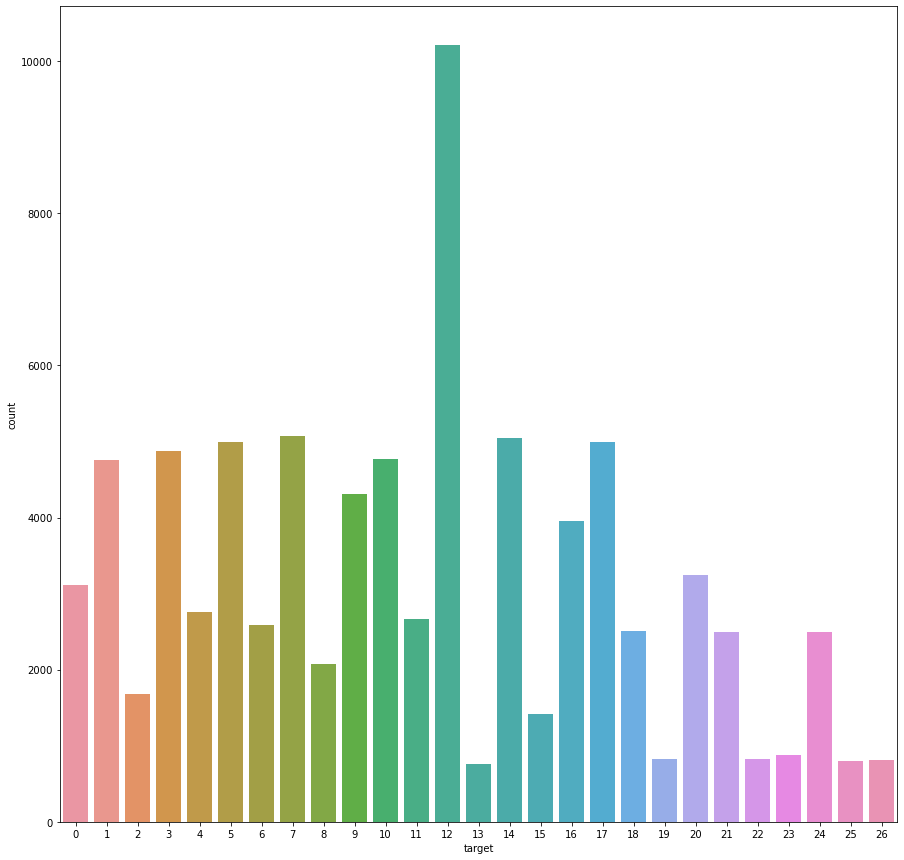

In [2]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.countplot(df['target'])

### Fonction pour F1 score

In [3]:
import tensorflow as tf
def macro_soft_f1(y, y_hat):

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0) # on multiplie la proba prédite d'un classe (y_hat) par son label=> Uniquement les proba des vrai positifs seront non nuls
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16) #  calcul du F1 score , 1e-16 pour ne pas diviser par 0
    cost = 1 - soft_f1 # comme on cherche a maximiser F1_score , et qu'il nous faut une fonction coût à minimiser duce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # on fait la moyenne pour tous les labels du batch
    return macro_cost

def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

## Division entrainement, test + preprocessing

In [4]:
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import layers
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization, RNN,Conv2D
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU,Flatten,Reshape,MaxPooling2D
from tensorflow.keras import regularizers

embedding_dim = 100
maxlen = 10

sentences = df['clean_title'].values
y = pd.get_dummies(df['target']).values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=0)


tokenizer = Tokenizer( filters='0123456789!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)



vocab_size = len(tokenizer.word_index) + 1


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Premier model : Conv1d

In [11]:
embedding_dim = 100
maxlen = 10

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Conv1D(64, 2, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(27, activation='softmax'))

         
model.compile(loss=macro_soft_f1, optimizer='adam', metrics=['accuracy',macro_f1])
#model.summary()

history = model.fit(X_train, y_train,
                   epochs= 20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size= 1000)

loss, accuracy, f1 = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy, f1 = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))




Epoch 1/20
68/68 [==============================] - 9s 123ms/step - loss: 0.9626 - accuracy: 0.1860 - macro_f1: 4.7948e-04 - val_loss: 0.8999 - val_accuracy: 0.3120 - val_macro_f1: 0.0835
Epoch 2/20
68/68 [==============================] - 8s 117ms/step - loss: 0.8388 - accuracy: 0.4017 - macro_f1: 0.1558 - val_loss: 0.6141 - val_accuracy: 0.5740 - val_macro_f1: 0.4236
Epoch 3/20
68/68 [==============================] - 8s 119ms/step - loss: 0.5582 - accuracy: 0.6226 - macro_f1: 0.4936 - val_loss: 0.4399 - val_accuracy: 0.6720 - val_macro_f1: 0.6099
Epoch 4/20
68/68 [==============================] - 8s 119ms/step - loss: 0.4021 - accuracy: 0.7150 - macro_f1: 0.6600 - val_loss: 0.3615 - val_accuracy: 0.7098 - val_macro_f1: 0.6816
Epoch 5/20
68/68 [==============================] - 8s 121ms/step - loss: 0.3052 - accuracy: 0.7658 - macro_f1: 0.7384 - val_loss: 0.3229 - val_accuracy: 0.7334 - val_macro_f1: 0.7093
Epoch 6/20
68/68 [==============================] - 9s 130ms/step - loss: 0.

## Matrice de confusion

              precision    recall  f1-score   support

           0       0.43      0.38      0.40       620
           1       0.76      0.77      0.76       951
           2       0.74      0.79      0.77       328
           3       0.61      0.74      0.67       943
           4       0.43      0.61      0.51       567
           5       0.88      0.90      0.89      1009
           6       0.77      0.68      0.72       501
           7       0.77      0.84      0.80       995
           8       0.62      0.43      0.51       390
           9       0.89      0.88      0.88       848
          10       0.72      0.69      0.71       943
          11       0.73      0.74      0.74       553
          12       0.84      0.97      0.90      1990
          13       0.74      0.54      0.63       155
          14       0.95      0.93      0.94      1004
          15       0.79      0.67      0.72       309
          16       0.92      0.91      0.91       788
          17       0.75    

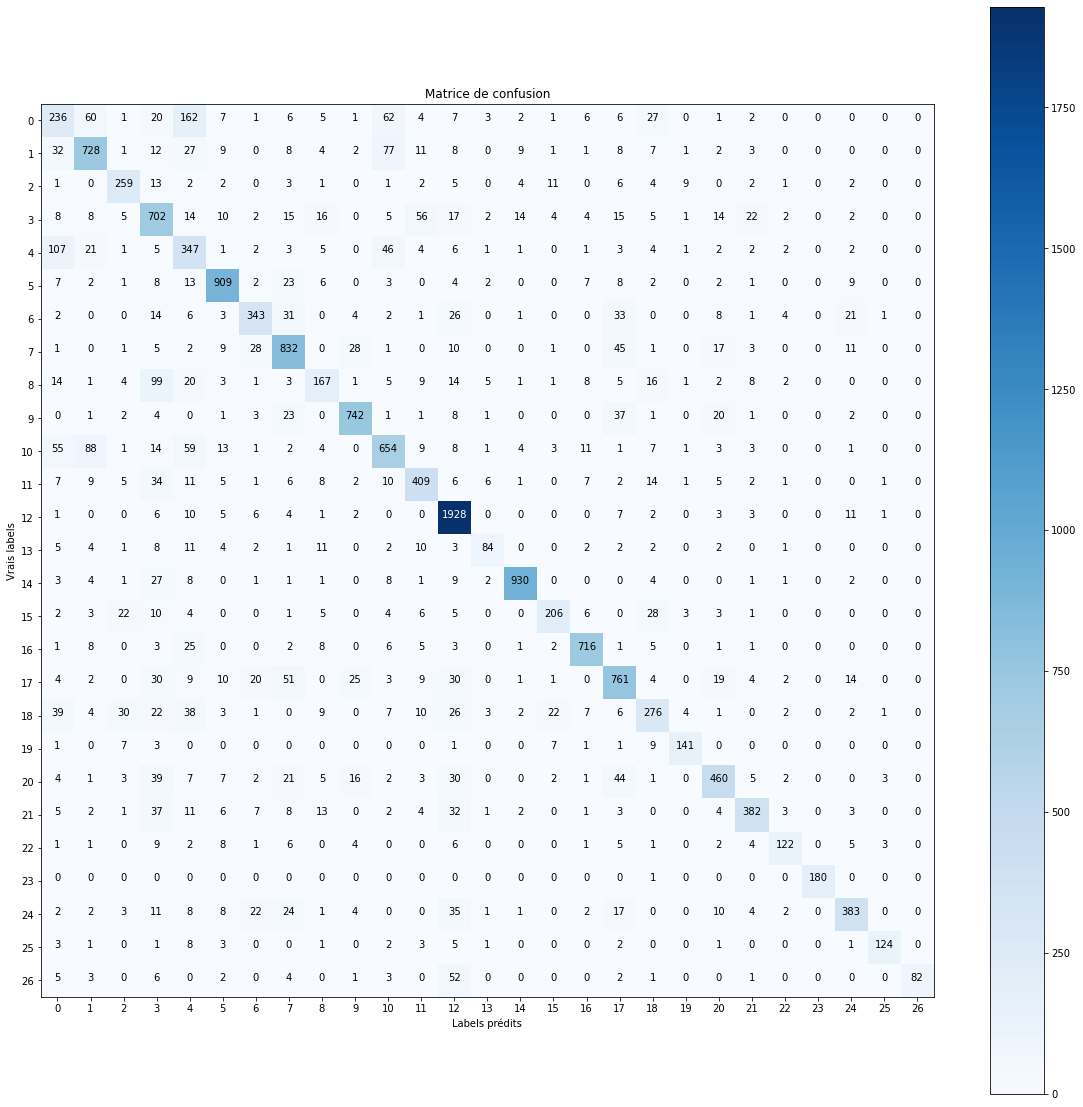

La classe 0 a souvent été prise pour la classe 1
La classe 0 a souvent été prise pour la classe 4
La classe 0 a souvent été prise pour la classe 10
La classe 0 a souvent été prise pour la classe 18
La classe 1 a souvent été prise pour la classe 0
La classe 1 a souvent été prise pour la classe 4
La classe 1 a souvent été prise pour la classe 10
La classe 3 a souvent été prise pour la classe 11
La classe 3 a souvent été prise pour la classe 21
La classe 4 a souvent été prise pour la classe 0
La classe 4 a souvent été prise pour la classe 1
La classe 4 a souvent été prise pour la classe 10
La classe 5 a souvent été prise pour la classe 7
La classe 6 a souvent été prise pour la classe 7
La classe 6 a souvent été prise pour la classe 12
La classe 6 a souvent été prise pour la classe 17
La classe 6 a souvent été prise pour la classe 24
La classe 7 a souvent été prise pour la classe 6
La classe 7 a souvent été prise pour la classe 9
La classe 7 a souvent été prise pour la classe 17
La classe 

In [12]:
import itertools
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
test_pred_class = y_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)
print(classification_report(y_test_class,test_pred_class))
cnf_matrix = metrics.confusion_matrix(y_test_class,test_pred_class)

classes = range(0,27)


plt.figure(figsize=(20,20))
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      if(cnf_matrix[i,j] >20 and i!=j):
          print("La classe {0} a souvent été prise pour la classe {1}".format(i,j))

## Accuracy et F1 score du modèle 

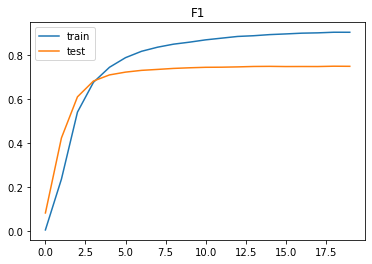

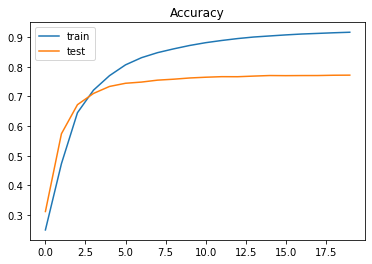

In [13]:
plt.title('F1')
plt.plot(history.history['macro_f1'], label='train')
plt.plot(history.history['val_macro_f1'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Deuxième modèle : LSTM

In [19]:
embedding_dim = 200
maxlen = 10


model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2.add(SpatialDropout1D(0.5))
model2.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model2.add(Dense(27, activation='softmax'))
model2.compile(loss=macro_soft_f1, optimizer='adam', metrics=['accuracy',macro_f1])
#model.summary()

history2 = model2.fit(X_train, y_train,
                   epochs= 30,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size= 1000)

loss, accuracy, f1 = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy, f1 = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))





Epoch 1/30
68/68 [==============================] - 53s 713ms/step - loss: 0.9534 - accuracy: 0.1625 - macro_f1: 0.0082 - val_loss: 0.8192 - val_accuracy: 0.3656 - val_macro_f1: 0.1430
Epoch 2/30
68/68 [==============================] - 49s 725ms/step - loss: 0.7740 - accuracy: 0.4106 - macro_f1: 0.1906 - val_loss: 0.5442 - val_accuracy: 0.5723 - val_macro_f1: 0.4784
Epoch 3/30
68/68 [==============================] - 51s 753ms/step - loss: 0.5408 - accuracy: 0.5718 - macro_f1: 0.4840 - val_loss: 0.4183 - val_accuracy: 0.6557 - val_macro_f1: 0.5989
Epoch 4/30
68/68 [==============================] - 49s 724ms/step - loss: 0.4266 - accuracy: 0.6551 - macro_f1: 0.5932 - val_loss: 0.3734 - val_accuracy: 0.6838 - val_macro_f1: 0.6416
Epoch 5/30
68/68 [==============================] - 52s 762ms/step - loss: 0.3661 - accuracy: 0.6977 - macro_f1: 0.6565 - val_loss: 0.3410 - val_accuracy: 0.7014 - val_macro_f1: 0.6676
Epoch 6/30
68/68 [==============================] - 55s 804ms/step - loss: 

## Matrice de confusion

              precision    recall  f1-score   support

           0       0.43      0.38      0.40       620
           1       0.76      0.77      0.76       951
           2       0.74      0.79      0.77       328
           3       0.61      0.74      0.67       943
           4       0.43      0.61      0.51       567
           5       0.88      0.90      0.89      1009
           6       0.77      0.68      0.72       501
           7       0.77      0.84      0.80       995
           8       0.62      0.43      0.51       390
           9       0.89      0.88      0.88       848
          10       0.72      0.69      0.71       943
          11       0.73      0.74      0.74       553
          12       0.84      0.97      0.90      1990
          13       0.74      0.54      0.63       155
          14       0.95      0.93      0.94      1004
          15       0.79      0.67      0.72       309
          16       0.92      0.91      0.91       788
          17       0.75    

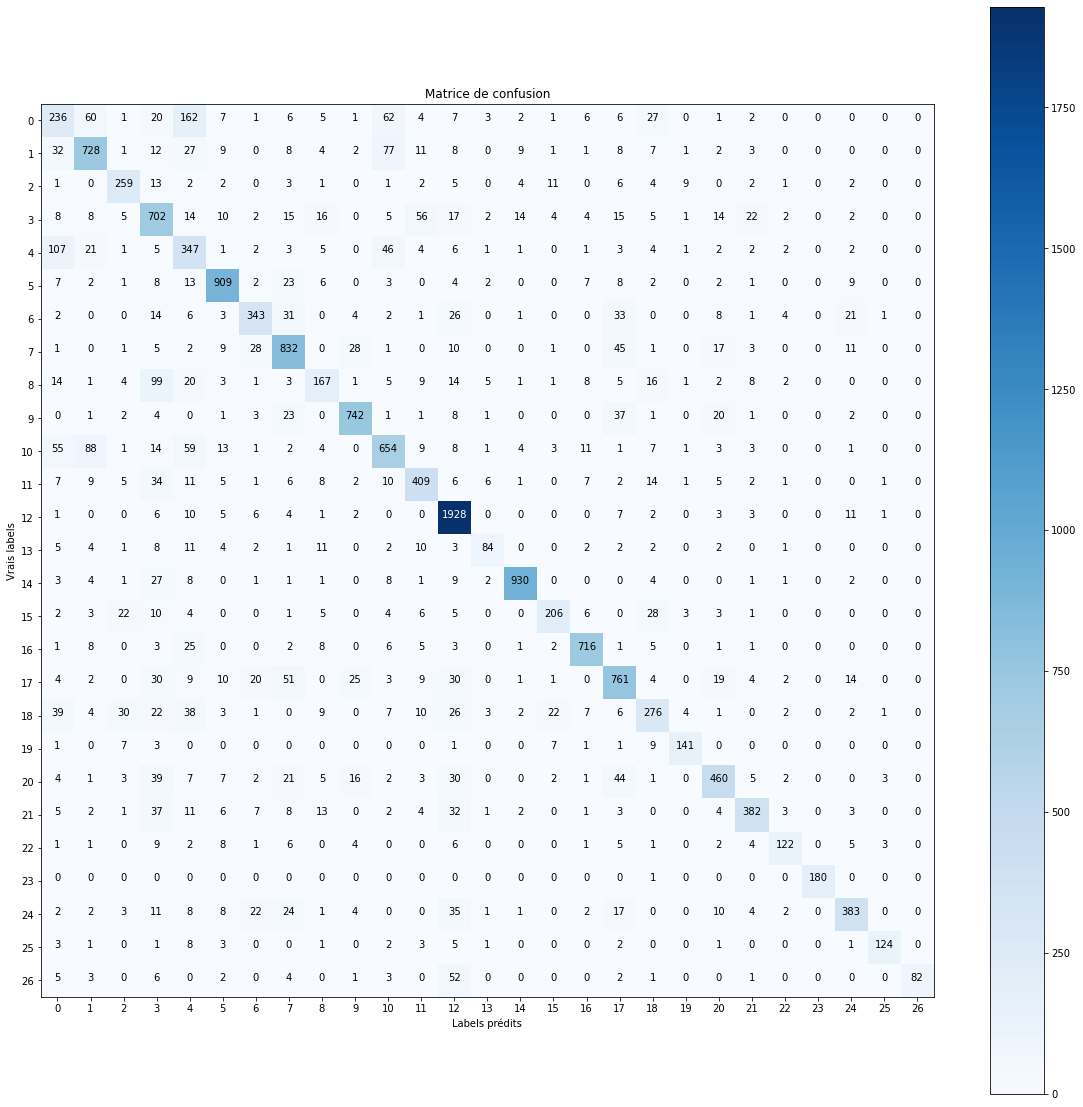

In [20]:
import itertools
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
test_pred_class = y_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)
print(classification_report(y_test_class,test_pred_class))
cnf_matrix = metrics.confusion_matrix(y_test_class,test_pred_class)

classes = range(0,27)


plt.figure(figsize=(20,20))
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

## Accuracy et F1 score 

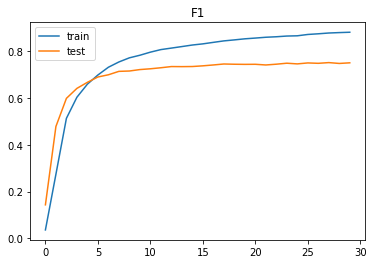

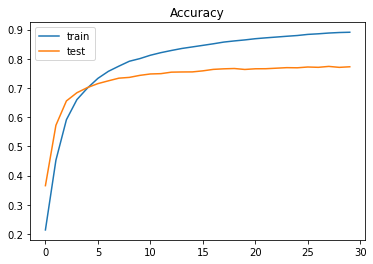

In [21]:
plt.title('F1')
plt.plot(history2.history['macro_f1'], label='train')
plt.plot(history2.history['val_macro_f1'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Troisième modèle : GRU

In [22]:
embedding_dim = 200
maxlen = 10



model3 = Sequential()
model3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model3.add(layers.SpatialDropout1D(0.5))
model3.add(layers.GRU(128, dropout=0.5, recurrent_dropout=0.5))
model3.add(layers.Dense(27, activation='softmax'))
       
model3.compile(loss=macro_soft_f1, optimizer='adam', metrics=['accuracy',macro_f1])
#model.summary()

history3 = model3.fit(X_train, y_train,
                   epochs= 30,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size= 5000)

loss, accuracy, f1 = model3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy, f1 = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))






Epoch 1/30
14/14 [==============================] - 26s 2s/step - loss: 0.9660 - accuracy: 0.0877 - macro_f1: 0.0000e+00 - val_loss: 0.9624 - val_accuracy: 0.1636 - val_macro_f1: 0.0000e+00
Epoch 2/30
14/14 [==============================] - 24s 2s/step - loss: 0.9599 - accuracy: 0.1712 - macro_f1: 2.8768e-04 - val_loss: 0.9443 - val_accuracy: 0.1895 - val_macro_f1: 0.0063
Epoch 3/30
14/14 [==============================] - 24s 2s/step - loss: 0.9353 - accuracy: 0.1927 - macro_f1: 0.0179 - val_loss: 0.8971 - val_accuracy: 0.2560 - val_macro_f1: 0.0729
Epoch 4/30
14/14 [==============================] - 23s 2s/step - loss: 0.8872 - accuracy: 0.2658 - macro_f1: 0.0767 - val_loss: 0.8324 - val_accuracy: 0.3142 - val_macro_f1: 0.1061
Epoch 5/30
14/14 [==============================] - 23s 2s/step - loss: 0.8249 - accuracy: 0.3330 - macro_f1: 0.1359 - val_loss: 0.7623 - val_accuracy: 0.3937 - val_macro_f1: 0.2038
Epoch 6/30
14/14 [==============================] - 22s 2s/step - loss: 0.7583

## Matrice de confusion

              precision    recall  f1-score   support

           0       0.43      0.38      0.40       620
           1       0.76      0.77      0.76       951
           2       0.74      0.79      0.77       328
           3       0.61      0.74      0.67       943
           4       0.43      0.61      0.51       567
           5       0.88      0.90      0.89      1009
           6       0.77      0.68      0.72       501
           7       0.77      0.84      0.80       995
           8       0.62      0.43      0.51       390
           9       0.89      0.88      0.88       848
          10       0.72      0.69      0.71       943
          11       0.73      0.74      0.74       553
          12       0.84      0.97      0.90      1990
          13       0.74      0.54      0.63       155
          14       0.95      0.93      0.94      1004
          15       0.79      0.67      0.72       309
          16       0.92      0.91      0.91       788
          17       0.75    

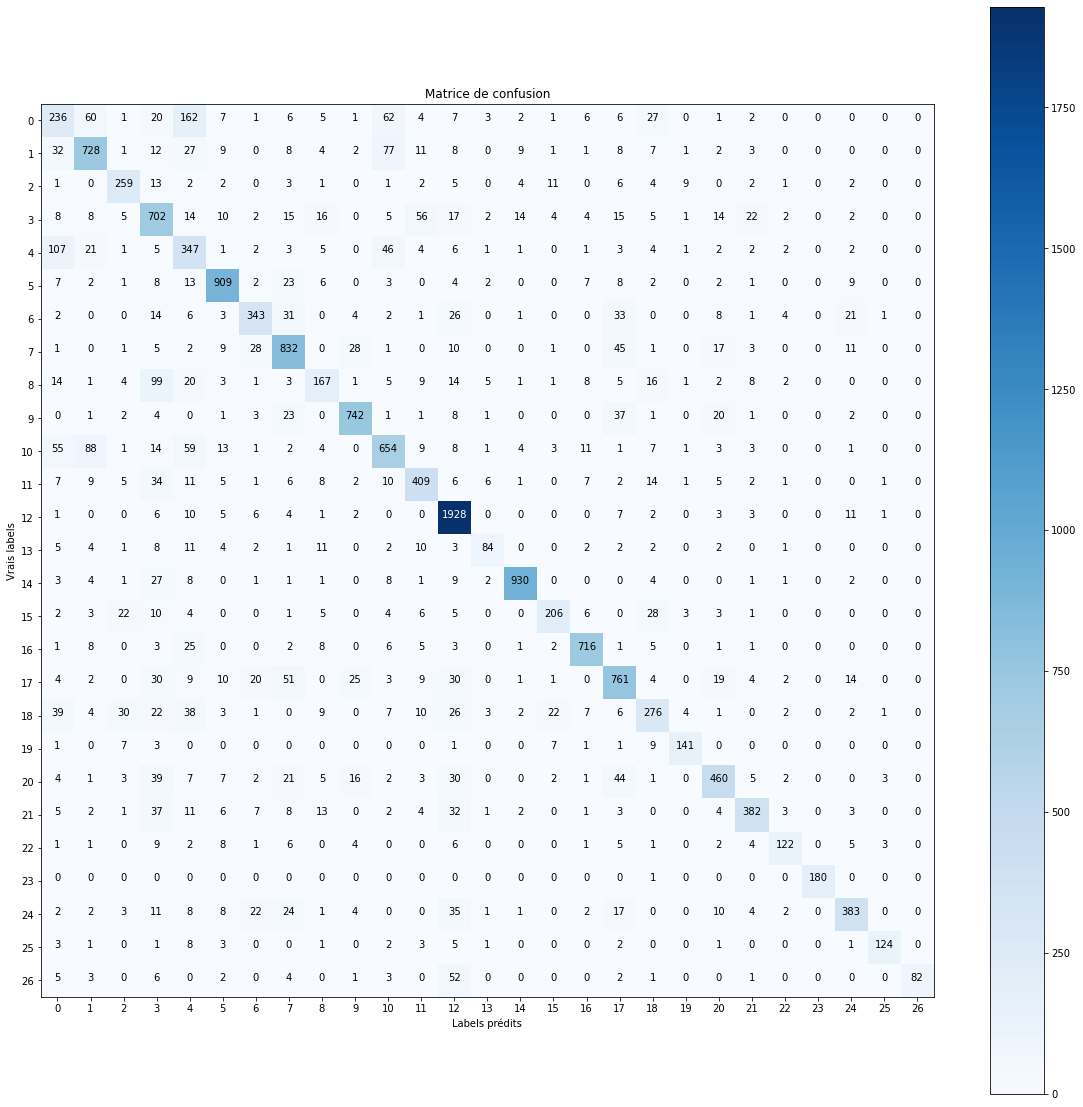

La classe 0 a souvent été prise pour la classe 1
La classe 0 a souvent été prise pour la classe 4
La classe 0 a souvent été prise pour la classe 10
La classe 0 a souvent été prise pour la classe 18
La classe 1 a souvent été prise pour la classe 0
La classe 1 a souvent été prise pour la classe 4
La classe 1 a souvent été prise pour la classe 10
La classe 3 a souvent été prise pour la classe 11
La classe 3 a souvent été prise pour la classe 21
La classe 4 a souvent été prise pour la classe 0
La classe 4 a souvent été prise pour la classe 1
La classe 4 a souvent été prise pour la classe 10
La classe 5 a souvent été prise pour la classe 7
La classe 6 a souvent été prise pour la classe 7
La classe 6 a souvent été prise pour la classe 12
La classe 6 a souvent été prise pour la classe 17
La classe 6 a souvent été prise pour la classe 24
La classe 7 a souvent été prise pour la classe 6
La classe 7 a souvent été prise pour la classe 9
La classe 7 a souvent été prise pour la classe 17
La classe 

In [25]:
import itertools
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
test_pred_class = y_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)
print(classification_report(y_test_class,test_pred_class))
cnf_matrix = metrics.confusion_matrix(y_test_class,test_pred_class)

classes = range(0,27)


plt.figure(figsize=(20,20))
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      if(cnf_matrix[i,j] >20 and i!=j):
          print("La classe {0} a souvent été prise pour la classe {1}".format(i,j))

## Accuracy et F1 score du modèle

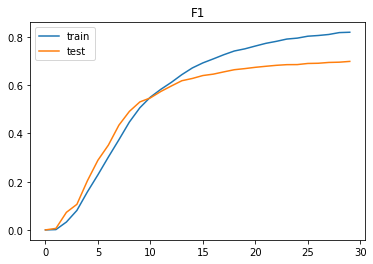

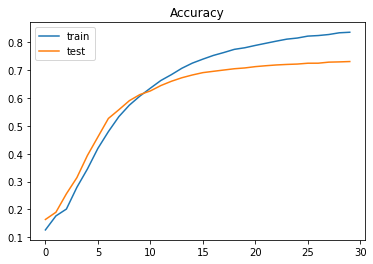

In [26]:
plt.title('F1')
plt.plot(history3.history['macro_f1'], label='train')
plt.plot(history3.history['val_macro_f1'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Test Undersampling sur un modèle ( Conv1d )

In [29]:
from imblearn.under_sampling import RandomUnderSampler
embedding_dim = 100
maxlen = 10

#Test du meilleur algo avec Undersampling pour équilibre des classes
sentences = df['clean_title'].values
y = pd.get_dummies(df['target']).values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=0)


tokenizer = Tokenizer( filters='0123456789!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)



vocab_size = len(tokenizer.word_index) + 1


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

rUs = RandomUnderSampler()
X_train, y_train = rUs.fit_resample(X_train, y_train)

model4 = Sequential()
model4.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model4.add(layers.SpatialDropout1D(0.2))
model4.add(layers.Conv1D(64, 2, activation='relu'))
model4.add(layers.GlobalMaxPooling1D())
model4.add(layers.Dense(27, activation='softmax'))

         
model4.compile(loss=macro_soft_f1, optimizer='adam', metrics=['accuracy',macro_f1])
#model.summary()

history4 = model4.fit(X_train, y_train,
                   epochs= 20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size= 100)

loss, accuracy, f1 = model4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy, f1 = model4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))





/Users/lucasgandy/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/20
165/165 [==============================] - 14s 76ms/step - loss: 0.9490 - accuracy: 0.1500 - macro_f1: 0.0167 - val_loss: 0.7930 - val_accuracy: 0.3827 - val_macro_f1: 0.1878
Epoch 2/20
165/165 [==============================] - 12s 74ms/step - loss: 0.6762 - accuracy: 0.4701 - macro_f1: 0.3280 - val_loss: 0.5886 - val_accuracy: 0.5357 - val_macro_f1: 0.4540
Epoch 3/20
165/165 [==============================] - 12s 74ms/step - loss: 0.4694 - accuracy: 0.6182 - macro_f1: 0.5823 - val_loss: 0.5214 - val_accuracy: 0.6057 - val_macro_f1: 0.5186
Epoch 4/20
165/165 [==============================] - 12s 72ms/step - loss: 0.3474 - accuracy: 0.7278 - macro_f1: 0.7010 - val_loss: 0.4899 - val_accuracy: 0.6404 - val_macro_f1: 0.5471
Epoch 5/20
165/165 [==============================] - 12s 72ms/step - loss: 0.2711 - accuracy: 0.7907 - macro_f1: 0.7642 - val_loss: 0.4710 - val_accuracy: 0.6607 - val_macro_f1: 0.5649
Epoch 6/20
165/165 [==============================] - 12s 73ms/step - 

## Accuracy et F1 score du modèle

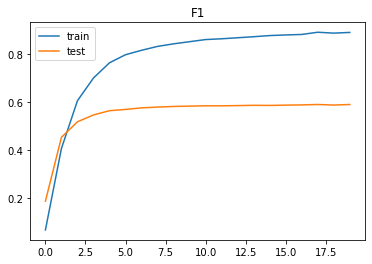

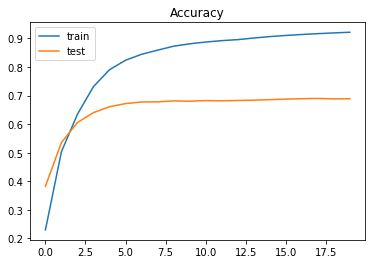

In [30]:
plt.title('F1')
plt.plot(history4.history['macro_f1'], label='train')
plt.plot(history4.history['val_macro_f1'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history4.history['accuracy'], label='train')
plt.plot(history4.history['val_accuracy'], label='test')
plt.legend()
plt.show();